# Preparación del entorno
### 1.1 Configuraión inicial

In [1]:
# Instalación de paquetes necesarios
# ! pip install tensorflow pandas numpy matplotlib seaborn scikit-learn

# Importación de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### 1.2 Carga y Exploración Inicial de Datos

Forma del dataset: (545, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None
              price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    545.000000  545.000000  

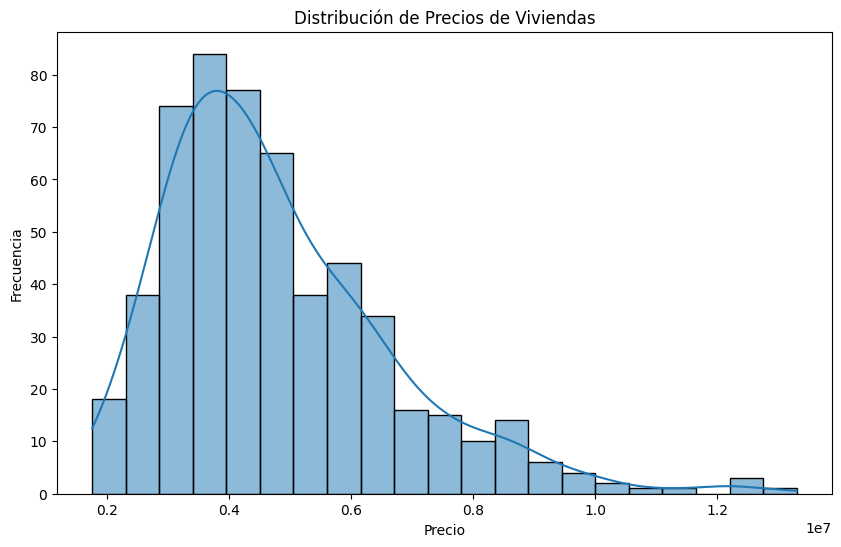

In [2]:
# Cargar el dataset
df = pd.read_csv('Housing.csv')

# Exploración inicial
print(f"Forma del dataset: {df.shape}")
print(df.info())
print(df.describe())

# Verificar valores nulos
print(f"Valores nulos por columna:\n{df.isnull().sum()}")

# Visualizar la distribución del precio
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Distribución de Precios de Viviendas')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()


## 2 Análisis Exploratorio de Datos (EDA)
### 2.1 Análisis de Correlaciones

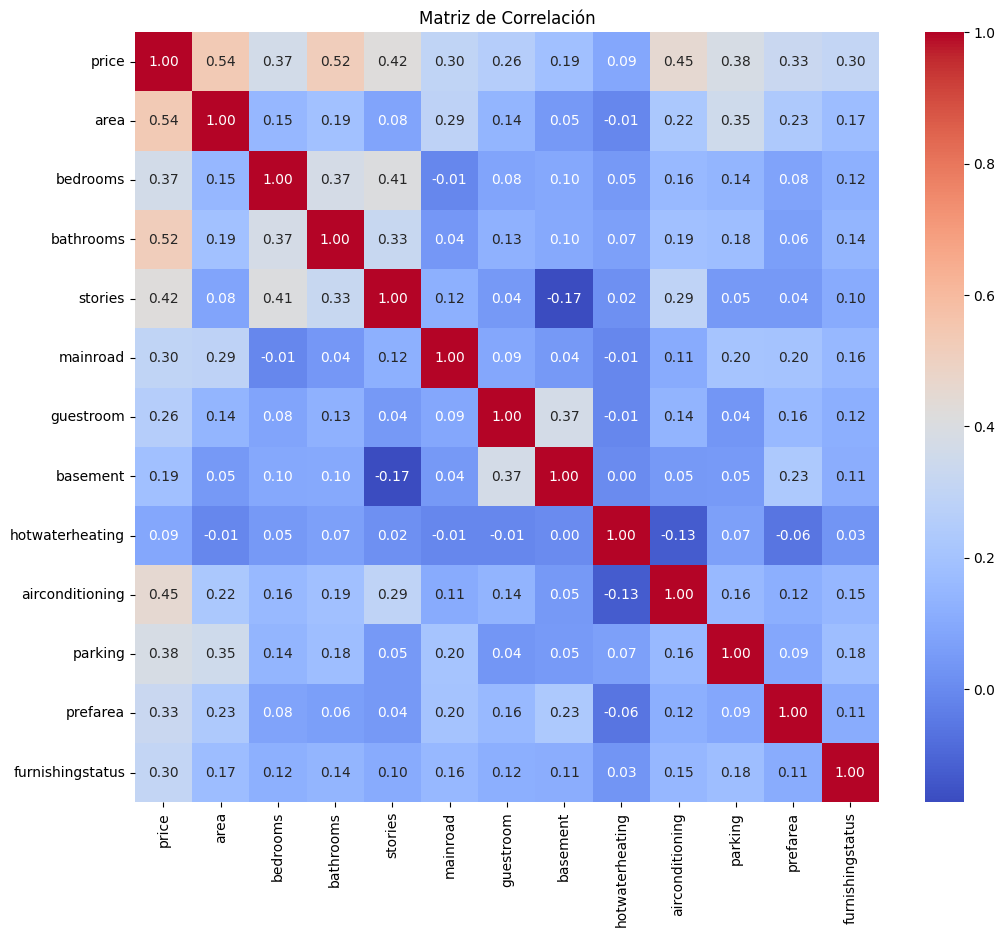

In [3]:
# Convertir variables categóricas a numéricas para análisis
df_numeric = df.copy()
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                    'airconditioning', 'prefarea', 'furnishingstatus']

# Codificación básica para visualización
for col in categorical_cols:
    if col != 'furnishingstatus':
        df_numeric[col] = df_numeric[col].map({'yes': 1, 'no': 0})
    else:
        df_numeric[col] = df_numeric[col].map({'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2})

# Matriz de correlación
plt.figure(figsize=(12, 10))
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()


### 2.2 Análisis de Variables Categóricas

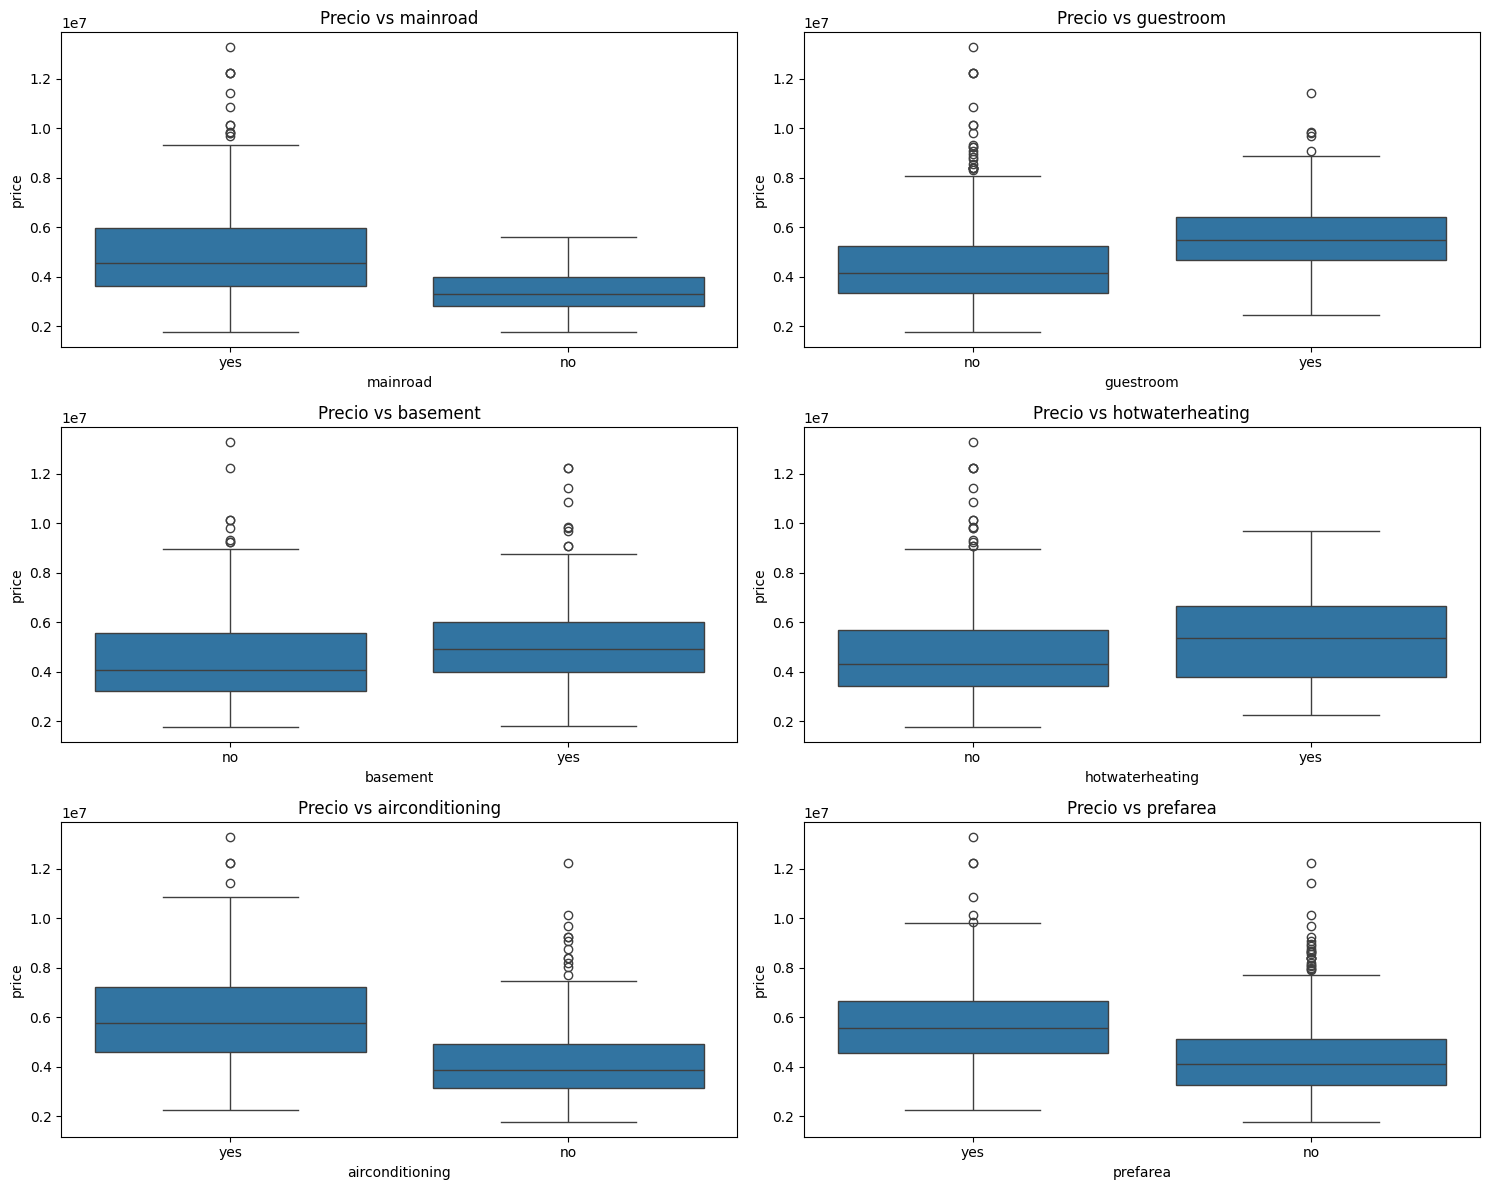

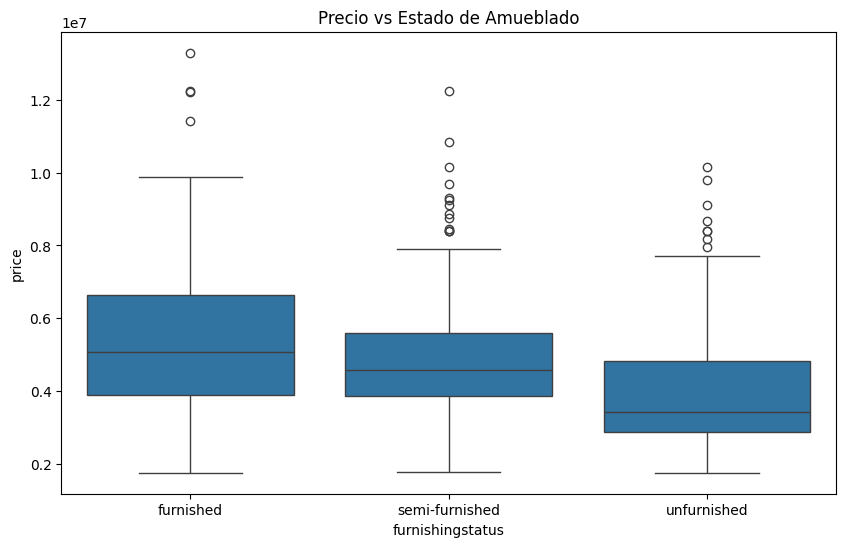

In [4]:
# Visualizar la relación entre variables categóricas y precio
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

categorical_binary = ['mainroad', 'guestroom', 'basement', 
                      'hotwaterheating', 'airconditioning', 'prefarea']

for i, cat_var in enumerate(categorical_binary):
    sns.boxplot(x=cat_var, y='price', data=df, ax=axes[i])
    axes[i].set_title(f'Precio vs {cat_var}')

plt.tight_layout()
plt.show()

# Analizar furnishingstatus
plt.figure(figsize=(10, 6))
sns.boxplot(x='furnishingstatus', y='price', data=df)
plt.title('Precio vs Estado de Amueblado')
plt.show()


### 2.3 Análisis de Variables Numéricas

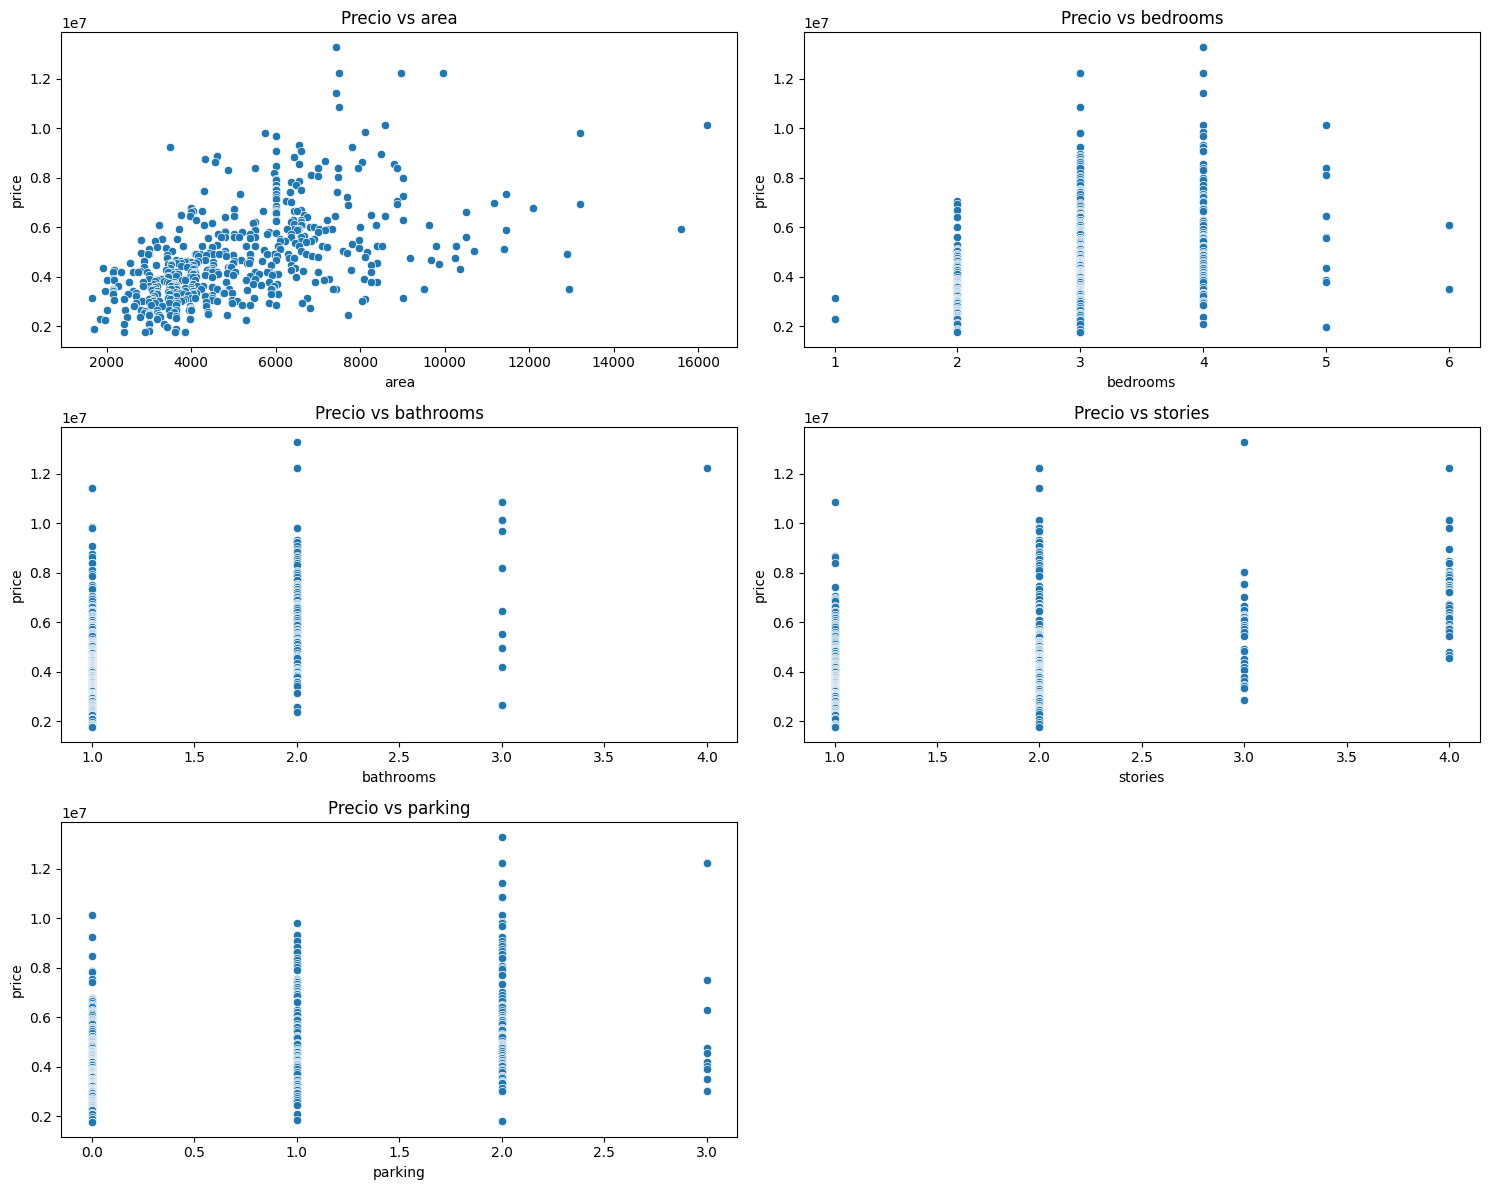

In [5]:
# Visualizar relaciones entre variables numéricas y precio
numeric_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    if i < len(axes):
        sns.scatterplot(x=feature, y='price', data=df, ax=axes[i])
        axes[i].set_title(f'Precio vs {feature}')

# Eliminar ejes sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 3. Preprocesamiento de Datos
## 3.1 División del Dataset

In [6]:
# # Dividir en conjuntos de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# def augment_data_numeric(X, y, num_samples=500):
#     np.random.seed(42)
#     # Seleccionar solo columnas numéricas
#     X_num = X.select_dtypes(include=[np.number])
    
#     # Generar índices aleatorios
#     idx1 = np.random.randint(0, len(X_num), num_samples)
#     idx2 = np.random.randint(0, len(X_num), num_samples)
    
#     # Interpolación entre puntos reales
#     alpha = np.random.uniform(0, 1, num_samples).reshape(-1, 1)
#     X_aug = alpha * X_num.iloc[idx1].values + (1 - alpha) * X_num.iloc[idx2].values
#     y_aug = alpha.flatten() * y.iloc[idx1].values + (1 - alpha.flatten()) * y.iloc[idx2].values
    
#     # Agregar ruido gaussiano
#     noise_X = np.random.normal(0, 0.01, X_aug.shape)
#     noise_y = np.random.normal(0, 0.01, y_aug.shape)
#     X_aug += noise_X
#     y_aug += noise_y
    
#     # Convertir a DataFrame y Series
#     X_aug_df = pd.DataFrame(X_aug, columns=X_num.columns)
#     y_aug_series = pd.Series(y_aug, name=y.name)
    
#     return X_aug_df, y_aug_series

# # Aplicar la augmentación solo sobre las columnas numéricas del conjunto de entrenamiento
# X_train_aug, y_train_aug = augment_data_numeric(X_train, y_train, num_samples=500)

# # Si lo deseas, concatena las nuevas muestras con el conjunto original de entrenamiento
# # Nota: Las columnas categóricas no se han modificado, por lo que aquí solo se aumentan las variables numéricas.
# X_train = pd.concat([X_train, X_train_aug], axis=0)
# y_train = pd.concat([y_train, y_train_aug], axis=0)


# print(X_train_aug.shape, y_train_aug.shape)
# print(X_train.shape, y_train.shape)


### 3.2 Transformación de Variables

In [27]:
# %% Feature Engineering usando la media de precio (global_mean_price)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Suponiendo que ya tienes cargado el DataFrame 'df'
# Separar características y variable objetivo
X = df.drop('price', axis=1)
y = df['price']

# Dividir en conjuntos de entrenamiento y prueba (calcular la media solo en entrenamiento)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calcular la media de precio en el conjunto de entrenamiento
global_mean_price = y_train.mean()
print("Global Mean Price (entrenamiento):", global_mean_price)

# Generar nuevas características usando la media de precio en lugar del valor individual
# Estas features reflejan, por ejemplo, el precio medio por unidad de área o por habitación
X_train['mean_price_per_area'] = global_mean_price / (X_train['area'] + 1)
X_train['mean_price_per_bedroom'] = global_mean_price / (X_train['bedrooms'] + 1)
X_train['mean_price_per_bathroom'] = global_mean_price / (X_train['bathrooms'] + 1)
X_train['mean_price_per_story'] = global_mean_price / (X_train['stories'] + 1)
X_train['mean_price_per_parking'] = global_mean_price / (X_train['parking'] + 1)
X_train['mean_price_per_total_room'] = global_mean_price / ((X_train['bedrooms'] + X_train['bathrooms']) + 1)
X_train['mean_price_area_bedrooms'] = global_mean_price / ((X_train['area'] * (X_train['bedrooms'] + 1)) + 1)

# Aplicar las mismas transformaciones al conjunto de prueba usando la misma media (calculada en entrenamiento)
X_test['mean_price_per_area'] = global_mean_price / (X_test['area'] + 1)
X_test['mean_price_per_bedroom'] = global_mean_price / (X_test['bedrooms'] + 1)
X_test['mean_price_per_bathroom'] = global_mean_price / (X_test['bathrooms'] + 1)
X_test['mean_price_per_story'] = global_mean_price / (X_test['stories'] + 1)
X_test['mean_price_per_parking'] = global_mean_price / (X_test['parking'] + 1)
X_test['mean_price_per_total_room'] = global_mean_price / ((X_test['bedrooms'] + X_test['bathrooms']) + 1)
X_test['mean_price_area_bedrooms'] = global_mean_price / ((X_test['area'] * (X_test['bedrooms'] + 1)) + 1)

# Visualizar un resumen de las nuevas features
print("X_train con nuevas features:")
print(X_train.head())

print("X_test con nuevas features:")
print(X_test.head())

# A partir de aquí, puedes continuar con el pipeline de preprocesamiento y modelado.

# %% Definir listas de columnas según su tipo
# Las nuevas features numéricas que no derivan del precio se incluirán en la parte continua.
continuous_features = ['area', 'bathrooms', 'area_per_bedroom', 'bathrooms_per_bedroom', 
                       'area_per_story', 'bedrooms_per_story', 'area_per_total_rooms', 'area_per_parking',
                       'mean_price_per_area', 'mean_price_per_bedroom', 'mean_price_per_bathroom', 
                       'mean_price_per_story', 'mean_price_per_parking', 'mean_price_per_total_room', 
                       'mean_price_area_bedrooms']

discrete_features = ['bedrooms', 'stories', 'parking', 'total_rooms']
# Variables categóricas y ordinales originales
categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
ordinal_features = ['furnishingstatus']

# %% Preprocesamiento
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

def log_transform(x):
    return np.log(x + 1)

# Pipeline para variables continuas: imputación -> log_transform -> escalado robusto
continuous_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transform', FunctionTransformer(log_transform)),
    ('scaler', RobustScaler())
])

# Pipeline para variables discretas: imputación -> escalado robusto
discrete_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Pipeline para variables categóricas: imputación -> One-Hot Encoding (drop='first' para evitar multicolinealidad)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

# Pipeline para variables ordinales: imputación -> codificación ordinal
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(
        categories=[['unfurnished', 'semi-furnished', 'furnished']],
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])

# Combinar todos los pipelines en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, continuous_features),
        ('disc', discrete_transformer, discrete_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
    ]
)

# Aplicar transformaciones
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Preprocesamiento de la variable objetivo (price): log-transform y escalado
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train_log.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test_log.values.reshape(-1, 1)).flatten()

print("Forma de X_train_processed:", X_train_processed.shape)


Global Mean Price (entrenamiento): 4706527.385321101
X_train con nuevas features:
     area  bedrooms  bathrooms  stories mainroad guestroom basement  \
46   6000         3          2        4      yes        no       no   
93   7200         3          2        1      yes        no      yes   
335  3816         2          1        1      yes        no      yes   
412  2610         3          1        2      yes        no      yes   
471  3750         3          1        2      yes        no       no   

    hotwaterheating airconditioning  parking  ... bedrooms_per_story  \
46               no             yes        1  ...                0.6   
93               no             yes        3  ...                1.5   
335              no             yes        2  ...                1.0   
412              no              no        0  ...                1.0   
471              no              no        0  ...                1.0   

    area_per_total_rooms  area_per_parking  mean_price_per

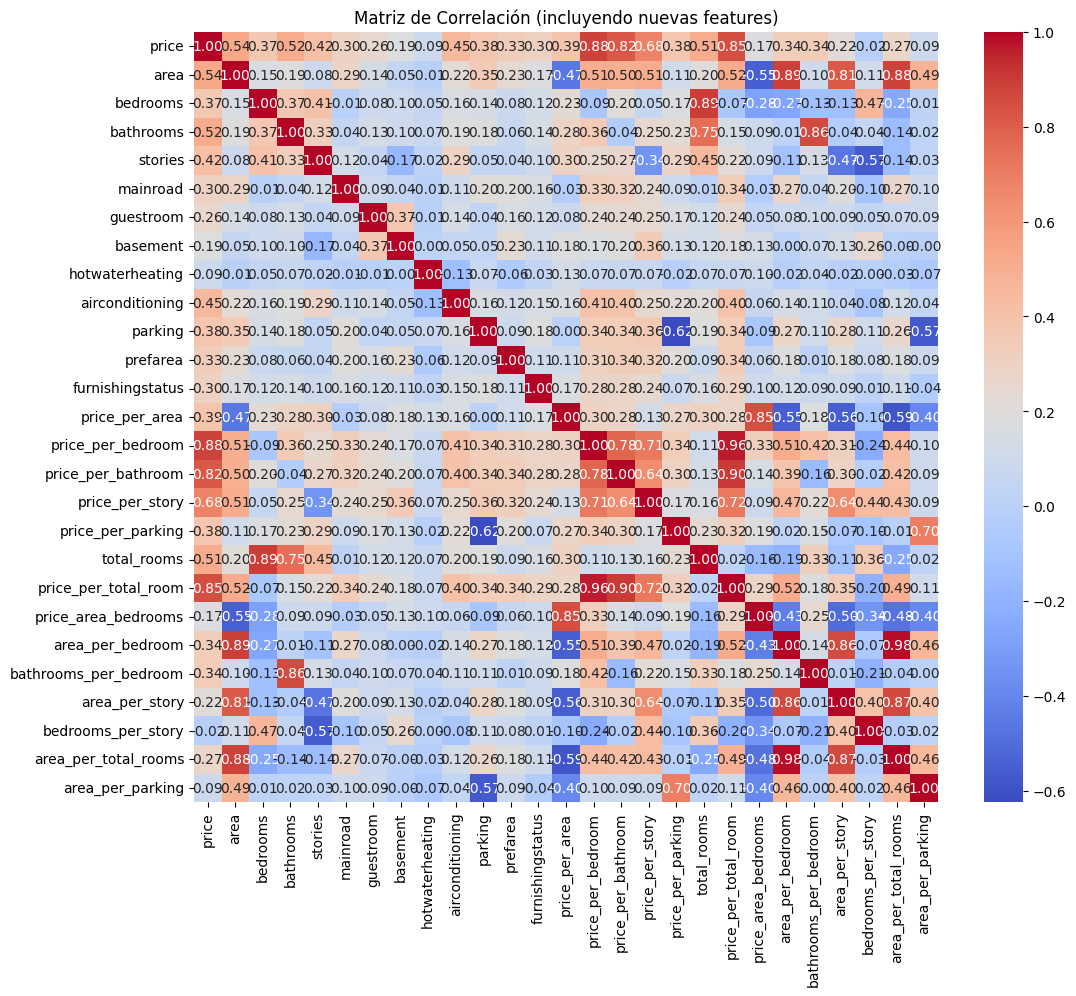

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una copia del DataFrame que incluye las nuevas features
df_numeric = df.copy()

# Definir las columnas categóricas a convertir
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                    'airconditioning', 'prefarea', 'furnishingstatus']

# Codificación básica para visualización: convertir variables categóricas a numéricas
for col in categorical_cols:
    if col != 'furnishingstatus':
        df_numeric[col] = df_numeric[col].map({'yes': 1, 'no': 0})
    else:
        df_numeric[col] = df_numeric[col].map({'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2})

# Calcular la matriz de correlación sobre todas las variables (incluidas las nuevas features)
plt.figure(figsize=(12, 10))
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación (incluyendo nuevas features)')

plt.show()


## 4 Construcción del Modelo con TensorFlow
### 4.1 Modelo Básico de Red Neuronal

In [29]:
# Determinar el número de características tras el preprocesamiento
num_features = X_train_processed.shape[1]

# Construir el modelo
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(num_features,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)  # Sin activación para regresión lineal
    ])
    
    model.compile(optimizer='adam',
                  loss='mse',  # Error cuadrático medio
                  metrics=['mae'])  # Error absoluto medio
    
    return model

# Crear y resumir el modelo
model = build_model()
model.summary()


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 64)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Entrenamiento del Modelo

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8137 - mae: 0.7250 - val_loss: 0.7662 - val_mae: 0.6961
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5325 - mae: 0.5674 - val_loss: 0.5850 - val_mae: 0.5900
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3793 - mae: 0.4830 - val_loss: 0.5008 - val_mae: 0.5470
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3496 - mae: 0.4473 - val_loss: 0.4652 - val_mae: 0.5197
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3023 - mae: 0.4263 - val_loss: 0.4459 - val_mae: 0.5073
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2451 - mae: 0.3743 - val_loss: 0.4302 - val_mae: 0.5003
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2736 - mae: 0.4021 - val_loss: 0.4254 - val_mae: 0.4991
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2527 - mae: 0.3794 - val_loss: 0.4107 - val_mae: 0.4907
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.23

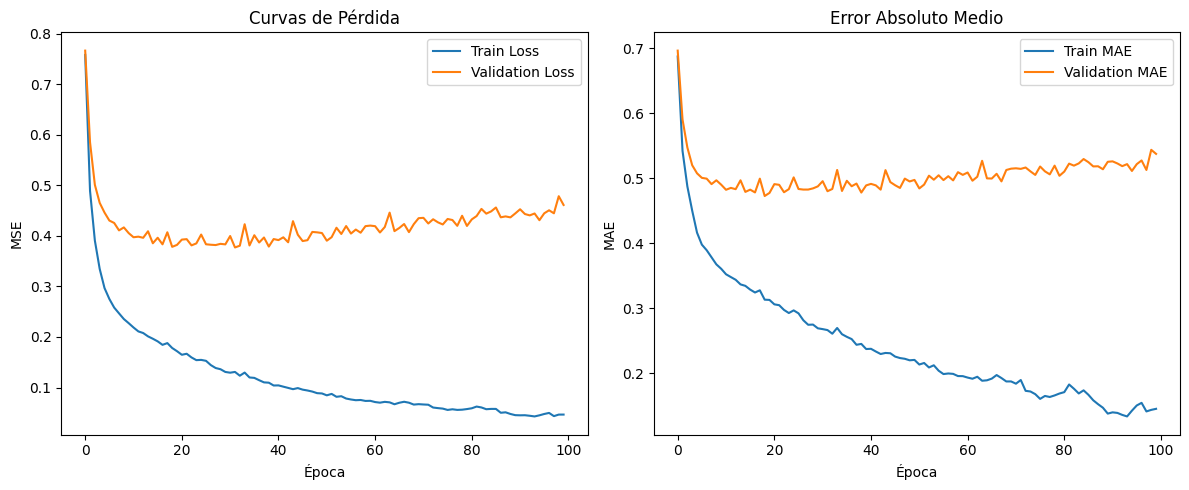

In [30]:
# Definir callbacks para monitoreo y early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    X_train_processed, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    # callbacks=[early_stopping],
    verbose=1
)

# Visualizar el proceso de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Curvas de Pérdida')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Error Absoluto Medio')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


### 4.3 Evaluación del Modelo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MSE: 2352952115200.00
RMSE: 1533933.54
RMSE (%): 30.63%
MAE: 1098066.50
R²: 0.53


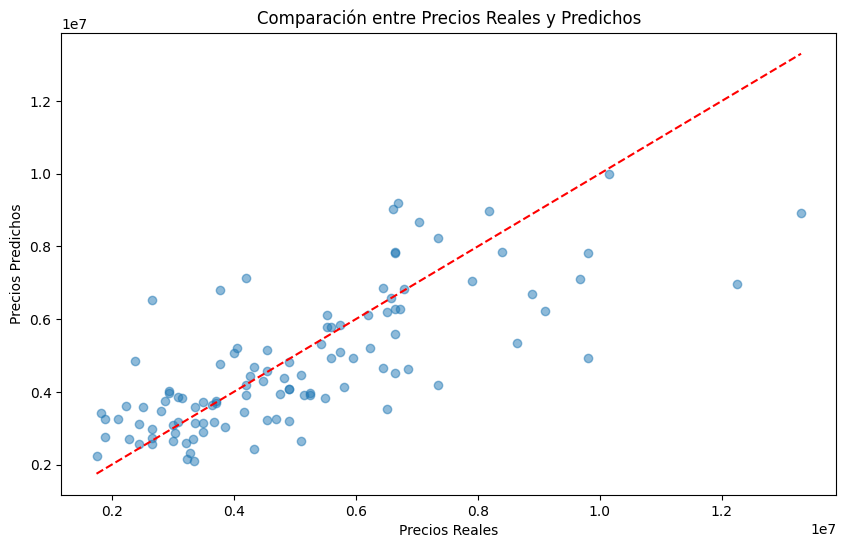

In [31]:
# Predicciones en conjunto de prueba
y_pred_scaled = model.predict(X_test_processed)

# Primero, revertir el escalado (inversa de StandardScaler)
y_pred_log = y_scaler.inverse_transform(y_pred_scaled)

# Luego, revertir la transformación logarítmica (inversa de np.log1p -> np.expm1)
y_pred = np.expm1(y_pred_log)

# Ahora, y_pred está en la escala original
y_true = y_test.values.reshape(-1, 1)

# Calcular métricas de evaluación
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Calcular RMSE en porcentaje respecto al valor medio de y_true
rmse_percent = (rmse / np.mean(y_true)) * 100

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"RMSE (%): {rmse_percent:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

# Visualizar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('Precios Reales')
plt.ylabel('Precios Predichos')
plt.title('Comparación entre Precios Reales y Predichos')
plt.show()


## 5. Optimización del Modelo
### 5.1 Ajuste de Hiperparámetros 

In [32]:
# Definir un conjunto de hiperparámetros para probar
def build_model_with_hyperparams(neurons_layer1, neurons_layer2, learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons_layer1, activation='relu', input_shape=(num_features,)),
        tf.keras.layers.Dense(neurons_layer2, activation='relu'),
        tf.keras.layers.Dropout(0.2),  # Añadir regularización
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Probar diferentes configuraciones
param_grid = [
    (128, 64, 0.001),
    (64, 32, 0.001),
    (32, 16, 0.001),
    (64, 32, 0.0001)
]

results = []

for params in param_grid:
    neurons_layer1, neurons_layer2, lr = params
    
    model = build_model_with_hyperparams(neurons_layer1, neurons_layer2, lr)
    
    history = model.fit(
        X_train_processed, y_train_scaled,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Evaluar en conjunto de prueba
    val_loss = min(history.history['val_loss'])
    
    results.append({
        'params': params,
        'val_loss': val_loss
    })
    
    print(f"Parámetros: {params}, Val Loss: {val_loss:.4f}")

# Identificar mejor configuración
best_params = min(results, key=lambda x: x['val_loss'])['params']
print(f"Mejor configuración: {best_params}")


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Parámetros: (128, 64, 0.001), Val Loss: 0.3805
Parámetros: (64, 32, 0.001), Val Loss: 0.3951
Parámetros: (32, 16, 0.001), Val Loss: 0.3997
Parámetros: (64, 32, 0.0001), Val Loss: 0.4795
Mejor configuración: (128, 64, 0.001)


### 5.2 Modelo Optimizado Final

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6954 - mae: 0.6430 - val_loss: 0.6572 - val_mae: 0.6311
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5447 - mae: 0.5776 - val_loss: 0.5362 - val_mae: 0.5511
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3745 - mae: 0.4814 - val_loss: 0.4919 - val_mae: 0.5228
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4294 - mae: 0.4908 - val_loss: 0.4612 - val_mae: 0.5095
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3777 - mae: 0.4828 - val_loss: 0.4500 - val_mae: 0.5016
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3777 - mae: 0.4866 - val_loss: 0.4336 - val_mae: 0.4920
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3025 - mae: 0.4273 - val_loss: 0.4348 - val_mae: 0.4923
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3644 - mae: 0.4729 - val_loss: 0.4203 - val_mae: 0.4834
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.31

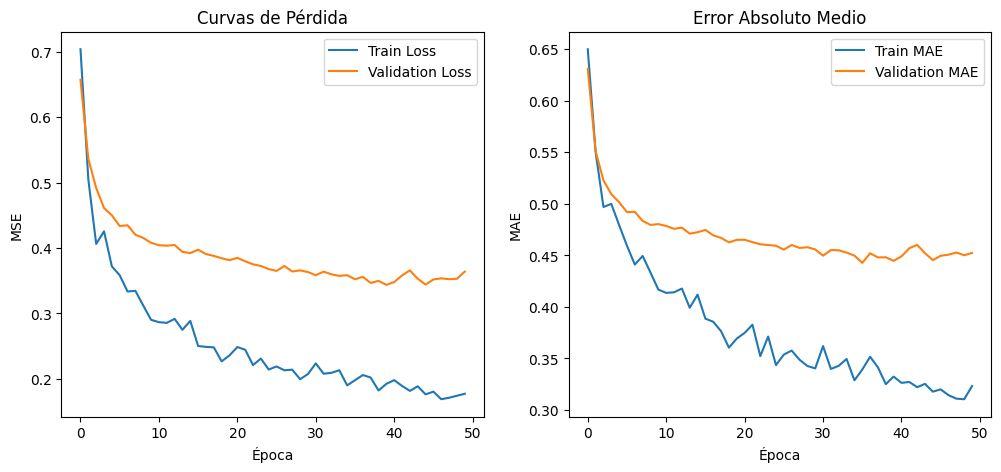

In [16]:
# Construir el modelo final con los mejores parámetros
neurons_layer1, neurons_layer2, lr = best_params

final_model = build_model_with_hyperparams(neurons_layer1, neurons_layer2, lr)

# Entrenar el modelo final
final_history = final_model.fit(
    X_train_processed, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Visualizar el proceso de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final_history.history['loss'], label='Train Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Curvas de Pérdida')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history.history['mae'], label='Train MAE')
plt.plot(final_history.history['val_mae'], label='Validation MAE')
plt.title('Error Absoluto Medio')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()


y_pred_final_scaled = final_model.predict(X_test_processed)

# 1) Deshacer el escalado
y_pred_final_log = y_scaler.inverse_transform(y_pred_final_scaled)

# 2) Deshacer el log
y_pred_final = np.expm1(y_pred_final_log)


# Calcular métricas finales
mse_final = mean_squared_error(y_true, y_pred_final)
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(y_true, y_pred_final)
r2_final = r2_score(y_true, y_pred_final)



print(f"MSE Final: {mse_final:.2f}")
print(f"RMSE Final: {rmse_final:.2f}")
print(f"MAE Final: {mae_final:.2f}")
print(f"R² Final: {r2_final:.2f}")




4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Métricas en test:
MSE: 1897645342720.00
RMSE: 1377550.49
RMSE (%): 27.51%
MAE: 1050722.88
R²: 0.62


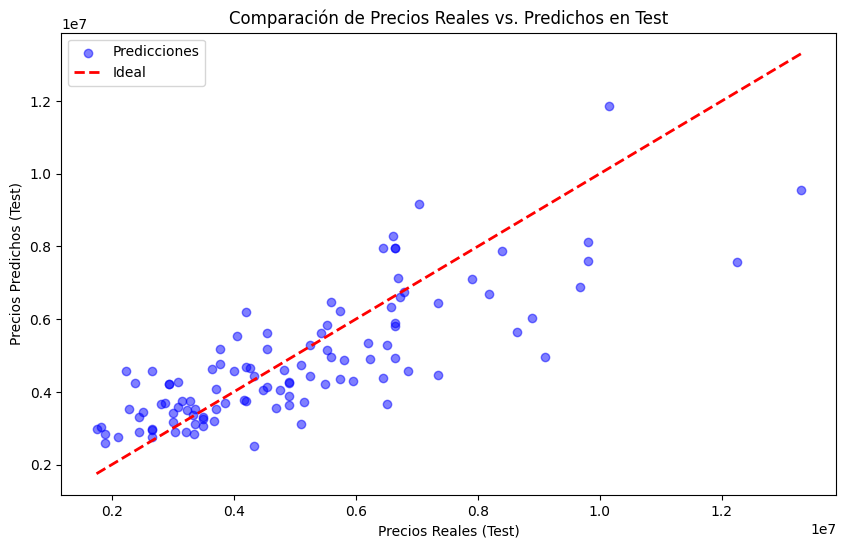

In [17]:
# Predicciones sobre el conjunto de test
y_test_pred_scaled = final_model.predict(X_test_processed)

# 1) Deshacer el escalado
y_test_pred_log = y_scaler.inverse_transform(y_test_pred_scaled)

# 2) Deshacer la transformación logarítmica (log1p)
y_test_pred = np.expm1(y_test_pred_log)

# Convertir y_test a matriz columna
y_test_true = y_test.values.reshape(-1, 1)

# Calcular métricas en el conjunto de test
mse_test = mean_squared_error(y_test_true, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_true, y_test_pred)
r2_test = r2_score(y_test_true, y_test_pred)
rmse_test_percent = (rmse_test / np.mean(y_test_true)) * 100

print("Métricas en test:")
print(f"MSE: {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"RMSE (%): {rmse_test_percent:.2f}%")
print(f"MAE: {mae_test:.2f}")
print(f"R²: {r2_test:.2f}")

# Visualizar predicciones vs. valores reales en test
plt.figure(figsize=(10, 6))
plt.scatter(y_test_true, y_test_pred, alpha=0.5, color='blue', label='Predicciones')
plt.plot([y_test_true.min(), y_test_true.max()],
         [y_test_true.min(), y_test_true.max()],
         'r--', lw=2, label='Ideal')
plt.xlabel('Precios Reales (Test)')
plt.ylabel('Precios Predichos (Test)')
plt.title('Comparación de Precios Reales vs. Predichos en Test')
plt.legend()
plt.show()


### 5.3 Análisis de Características e Interpretabilidad

c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Número de características extraídas: 26
Número de pesos: 26


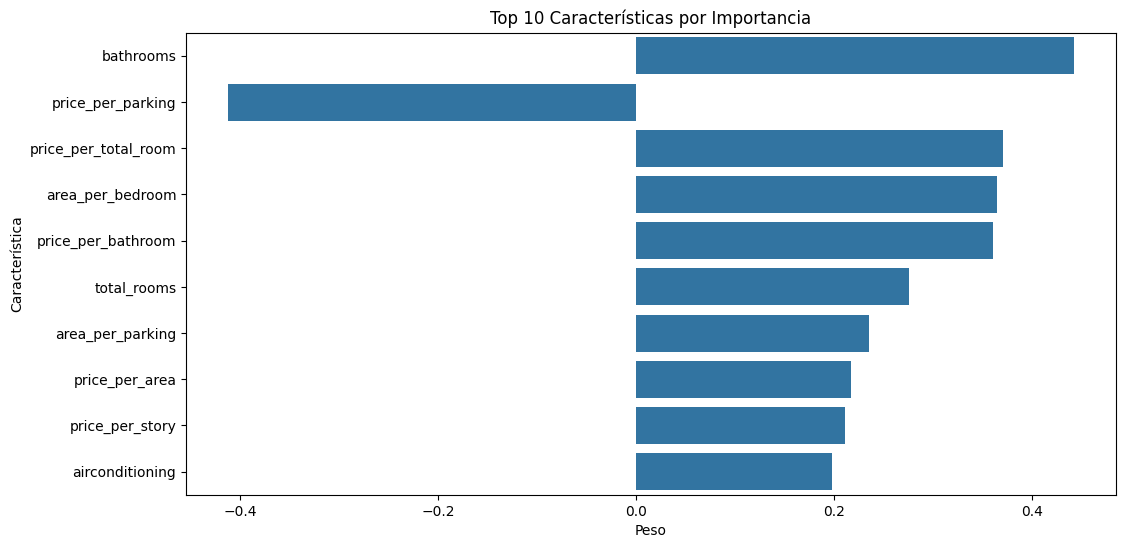

In [89]:
# Construir un modelo más simple para análisis de características
simple_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(num_features,), use_bias=False)
])

simple_model.compile(optimizer='adam', loss='mse')
simple_model.fit(X_train_processed, y_train_scaled, epochs=50, batch_size=32, verbose=0)

# Obtener los pesos del modelo
feature_weights = simple_model.get_weights()[0].flatten()

# Obtener nombres de características después del preprocesamiento
feature_names = []
for name, transformer, features in preprocessor.transformers_:
    if name in ['cont', 'disc']:
        # Agregamos directamente los nombres de las características continuas o discretas
        feature_names.extend(features)
    elif name == 'cat':
        # Para OneHotEncoder (drop='first') se suele obtener una columna por característica (si son binarias)
        for feature in features:
            feature_names.append(f"{feature}")
    elif name == 'ord':
        # Para variables ordinales se conserva el nombre original
        for feature in features:
            feature_names.append(feature)

# Verificar que la longitud de feature_names coincide con la de feature_weights
print("Número de características extraídas:", len(feature_names))
print("Número de pesos:", len(feature_weights))

# Crear DataFrame para visualización
importance_df = pd.DataFrame({
    'Feature': feature_names,  # ahora deberían tener la misma longitud
    'Weight': feature_weights
})

# Ordenar por valor absoluto del peso y seleccionar las 10 más importantes
importance_df['AbsWeight'] = importance_df['Weight'].abs()
importance_df = importance_df.sort_values('AbsWeight', ascending=False).head(10)

# Visualizar importancia de características
plt.figure(figsize=(12, 6))
sns.barplot(x='Weight', y='Feature', data=importance_df)
plt.title('Top 10 Características por Importancia')
plt.xlabel('Peso')
plt.ylabel('Característica')
plt.show()


### 5.4 Implementación para Predicciones

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
   Precio Real  Precio Predicho
0      4060000       3865244.50
1      6650000       6399582.00
2      3710000       3670893.00
3      6440000       6379345.50
4      2800000       2881066.75


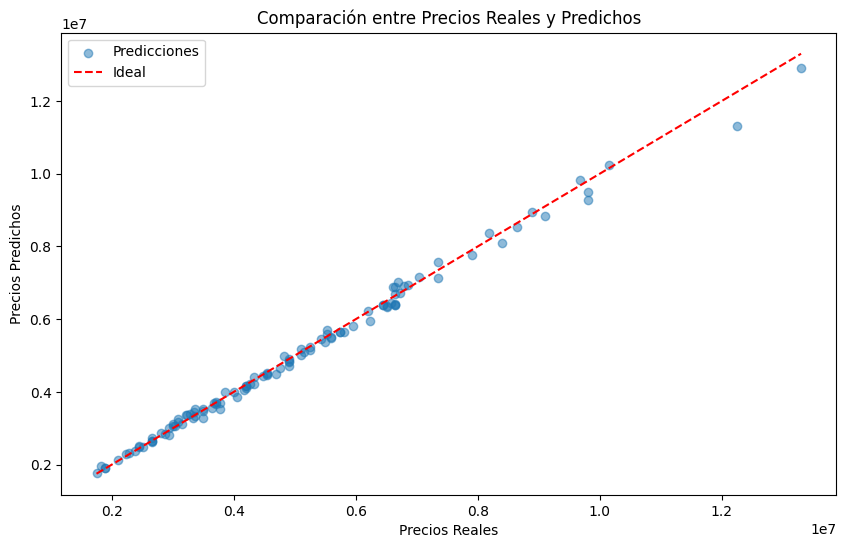

In [90]:
# Predicciones sobre el conjunto de test
y_pred_scaled = final_model.predict(X_test_processed)
y_pred_log = y_scaler.inverse_transform(y_pred_scaled)
y_pred = np.expm1(y_pred_log)


import pandas as pd

# Crear DataFrame comparativo
df_comparativa = pd.DataFrame({
    'Precio Real': y_true.flatten(),
    'Precio Predicho': y_pred.flatten()
})

print(df_comparativa.head())

import matplotlib.pyplot as plt

# Visualizar la comparación entre precios reales y predichos
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, label='Predicciones')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Ideal')
plt.xlabel('Precios Reales')
plt.ylabel('Precios Predichos')
plt.title('Comparación entre Precios Reales y Predichos')
plt.legend()
plt.show()


## 6. Evaluacion, Guardado y carga del modelo
### 6.1 Guardado

In [57]:
# Guardar el modelo
tf.saved_model.save(model, 'house_price_model_saved_model')

# Cargar el modelo
loaded_model = tf.saved_model.load('house_price_model_saved_model')

# Para hacer predicciones, necesitas obtener la función de inferencia del modelo cargado
infer = loaded_model.signatures["serving_default"]


INFO:tensorflow:Assets written to: house_price_model_saved_model\assets


INFO:tensorflow:Assets written to: house_price_model_saved_model\assets


### 6.2 Validación Cruzada para Evaluación Robusta

In [58]:
from sklearn.model_selection import KFold

# Configurar validación cruzada
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

cv_scores = []

# Función para crear y entrenar modelo
def create_and_train_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(num_features,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Realizar validación cruzada
print("Iniciando validación cruzada...")
fold = 1

X_processed = preprocessor.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

for train_idx, test_idx in kf.split(X_processed):
    X_train_fold, X_test_fold = X_processed[train_idx], X_processed[test_idx]
    y_train_fold, y_test_fold = y_scaled[train_idx], y_scaled[test_idx]
    
    # Crear y entrenar modelo
    fold_model = create_and_train_model()
    fold_model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)
    
    # Evaluar
    y_pred_fold = fold_model.predict(X_test_fold)
    mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
    
    cv_scores.append(mse_fold)
    print(f"Fold {fold}: MSE = {mse_fold:.4f}")
    fold += 1

print(f"Promedio MSE en validación cruzada: {np.mean(cv_scores):.4f}")
print(f"Desviación estándar: {np.std(cv_scores):.4f}")


Iniciando validación cruzada...


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Fold 1: MSE = 0.5387


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 2: MSE = 0.4054


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Fold 3: MSE = 0.2779


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 4: MSE = 0.3214


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Fold 5: MSE = 0.3307
Promedio MSE en validación cruzada: 0.3748
Desviación estándar: 0.0916


### 6.3 Carga

In [59]:
import tensorflow as tf

# Cargar el modelo
loaded_model = tf.saved_model.load('house_price_model_saved_model')

# Imprimir las firmas del modelo
print(loaded_model.signatures)


_SignatureMap({'serving_default': <ConcreteFunction (*, inputs: TensorSpec(shape=(None, 14), dtype=tf.float32, name='inputs')) -> Dict[['output_0', TensorSpec(shape=(None, 1), dtype=tf.float32, name='output_0')]] at 0x26E396DEC50>})


In [60]:
print(loaded_model.signatures['serving_default'].structured_outputs)


{'output_0': TensorSpec(shape=(None, 1), dtype=tf.float32, name='output_0')}


## 7. Inferencia

In [61]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pickle
import pandas as pd

# Paso 7: Cargar el modelo usando tf.saved_model
loaded_model = tf.saved_model.load('house_price_model_saved_model')

# Paso 8: Cargar el scaler
with open('scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

# Paso 9: Preparar nuevos datos para la predicción
new_data = pd.DataFrame({
    'area': [7420],
    'bedrooms': [4],
    'bathrooms': [2],
    'stories': [3],
    'mainroad': [1],
    'guestroom': [0],
    'basement': [0],
    'hotwaterheating': [0],
    'airconditioning': [1],
    'parking': [2],
    'prefarea': [1],
    'furnishingstatus_semi-furnished': [0],
    'furnishingstatus_unfurnished': [0]
})

# Paso 10: Escalar los nuevos datos
new_data_scaled = loaded_scaler.transform(new_data)

# Paso 11: Obtener la función de inferencia del modelo cargado
infer = loaded_model.signatures["serving_default"]

# Paso 12: Realizar la predicción
prediction = infer(tf.constant(new_data_scaled, dtype=tf.float32))

# Ajusta el nombre de la capa aquí
nombre_capa_salida = list(prediction.keys())[0]  # Obtener el primer nombre de clave
print(nombre_capa_salida)

# Ajusta el nombre de la capa aquí
print(f"Predicción del precio de la vivienda: {prediction[nombre_capa_salida].numpy()[0][0]:.2f}")


InvalidArgumentError: Graph execution error:

Detected at node StatefulPartitionedCall/sequential_22_1/dense_66_1/Relu defined at (most recent call last):
<stack traces unavailable>
Matrix size-incompatible: In[0]: [1,13], In[1]: [14,64]
	 [[{{node StatefulPartitionedCall/sequential_22_1/dense_66_1/Relu}}]] [Op:__inference_signature_wrapper_serving_default_170577]